# <center> Projet clustering cartes de crédit </center>


<center> Pour ce projet nous allons nous intérésser à la segmentation client des utilisateurs de carte de crédit

### Table des matières

  
   

* [Importation des bilbiothèques](#chapter1)
    * [Chargement des données](#section_1_1)
    * [Traitement des données](#section_1_2)
        * [Transformation des données](#section_1_2_1)
* [Visualisation des données](#chapter2)
    * [Distribution](#section_2_1)
    * [Heatmap](#section_2_2)
* [Entrainement du modèle](#chapter3)
    * [Application de l'ACP](#section_3_1)
    * [Calcul du nombre de cluster](#section_3_2)
* [Evaluation du modele](#chapter4)
    * [Affichage de la silhouette scores ](#section_4_1)
    * [Visualisation de nos clusters](#section_4_2)
* [Deploiement](#chapter5)

### 1.Importation des bibliothèques <a class="anchor" id="chapter1"></a>

In [45]:
#structuration des données et manipulation
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
import pickle
from sklearn import preprocessing,decomposition
from scipy.cluster.hierarchy import *
from scipy import stats

In [46]:
#!pip freeze

#### Chargement des données <a class="anchor" id="section_1_1"></a>

In [47]:
df_CC =  pd.read_csv('CC_GENERAL.csv')
#Importation de notre csv
#df_tenants.to_csv("test2.csv", sep=',', encoding='utf-8', quotechar='"', decimal='.')

In [48]:
#from pandas_profiling import ProfileReport
#profile_cc = ProfileReport(df_CC)
#profile_cc

In [49]:
df_CC.head() #On affiche les 5 premières lignes

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


    Explication de chacuns de nos features :

    CUST_ID = Identifiant du titulaire de la carte bancaire 
    BALANCE = Montant du solde restant sur leur compte pour effectuer des achats
    BALANCE_FREQUENCY = Fréquence de mise à jour du solde, score compris entre 0 et 1 (1 = fréquemment mis à jour, 0 = pas fréquemment mis à jour)
    PURCHASES = Montant des achats effectués à partir du compte
    ONEOFF_PURCHASES = Montant d'achat maximal effectué en une seule fois
    INSTALLMENTS_PURCHASES = Montant de l'achat effectué en plusieurs fois
    CASH_ADVANCE = Paiement d'avance donné par l'utilisateur
    PURCHASES_FREQUENCY = À quelle fréquence les achats sont effectués, score entre 0 et 1 (1 = fréquemment acheté, 0 = pas souvent acheté)
    ONEOFFPURCHASESFREQUENCY =Fréquence des achats en une seule fois (1 = fréquemment acheté, 0 = pas fréquemment acheté)
    PURCHASESINSTALLMENTSFREQUENCY : Fréquence des achats à tempérament (1 = fréquemment acheté, 0 = pas fréquemment acheté).
    CASHADVANCEFREQUENCY : Fréquence des paiements d'avance en espèces.
    CASHADVANCETRX : Nombre de transactions effectuées avec "Cash in Advanced".
    PURCHASESTRX : Nombre de transactions d'achat effectuées.
    CREDITLIMIT : Limite de la carte de crédit de l'utilisateur.
    PAYMENTS : Montant des paiements effectués par l'utilisateur
    MINIMUM_PAYMENTS : Montant minimum des paiements effectués par l'utilisateur
    PRCFULLPAYMENT : Pourcentage du paiement total payé par l'utilisateur
    TENURE : Durée du service de carte de crédit pour l'utilisateur.


In [50]:
df_CC.describe() #description de notre dataset 

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [51]:
df_CC.info() #Quelques infos de ntore dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
CUST_ID                             8950 non-null object
BALANCE                             8950 non-null float64
BALANCE_FREQUENCY                   8950 non-null float64
PURCHASES                           8950 non-null float64
ONEOFF_PURCHASES                    8950 non-null float64
INSTALLMENTS_PURCHASES              8950 non-null float64
CASH_ADVANCE                        8950 non-null float64
PURCHASES_FREQUENCY                 8950 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8950 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8950 non-null float64
CASH_ADVANCE_FREQUENCY              8950 non-null float64
CASH_ADVANCE_TRX                    8950 non-null int64
PURCHASES_TRX                       8950 non-null int64
CREDIT_LIMIT                        8949 non-null float64
PAYMENTS                            8950 non-null float64
MINIMUM_PAYMENTS            

#### Traitement des données <a class="anchor" id="section_1_2"></a>

In [52]:
df_CC.isna().mean()*100
#Ici on observe des données manquantes au niveau du minimum_payments
#et du credit_Limit, on va essayer par la suite de combler ce manque.

CUST_ID                             0.000000
BALANCE                             0.000000
BALANCE_FREQUENCY                   0.000000
PURCHASES                           0.000000
ONEOFF_PURCHASES                    0.000000
INSTALLMENTS_PURCHASES              0.000000
CASH_ADVANCE                        0.000000
PURCHASES_FREQUENCY                 0.000000
ONEOFF_PURCHASES_FREQUENCY          0.000000
PURCHASES_INSTALLMENTS_FREQUENCY    0.000000
CASH_ADVANCE_FREQUENCY              0.000000
CASH_ADVANCE_TRX                    0.000000
PURCHASES_TRX                       0.000000
CREDIT_LIMIT                        0.011173
PAYMENTS                            0.000000
MINIMUM_PAYMENTS                    3.497207
PRC_FULL_PAYMENT                    0.000000
TENURE                              0.000000
dtype: float64

##### Transformation des données <a class="anchor" id="section_1_2_1"></a>

In [53]:
df_CC.drop(['CUST_ID'], axis=1, inplace=True)
#Petit nettoyage de notre premier features qui ne sera pas nécessaire pour la suite

In [54]:
df_CC.dropna(subset=['CREDIT_LIMIT'], inplace=True) 
#Ici comme notre colonne CREDIT_LIMIT a seulement 0.01% de valeurs manquante on va juste les supprimer
#ça n'aura aucun impact pour la suite, subset c'est pour définir dans quelle colonne on cherche les
#valeurs manquantes

In [55]:
df_CC.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [56]:
dfmean = df_CC['MINIMUM_PAYMENTS'].mean()
dfmed= df_CC['MINIMUM_PAYMENTS'].median()
dfmean,dfmed

#Au vu des résultats on va donc imputer par la median car la moyenne se rapproche trop du 3 eme
#Quartile

(864.3049429326062, 312.4522915)

In [57]:
df_CC['MINIMUM_PAYMENTS'].fillna(df_CC['MINIMUM_PAYMENTS'].median(), inplace = True)
df_CC.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.452292,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### Visualisation des données <a class="anchor" id="chapter2"></a>

Pour la partie visualisation on va afficher la distribution des observations pour chacunes de nos colonnes

On peut voir la distribution n'est pas homogene partout mais ça c'est normal, les clients n'ont pas tous les mêmes revenues et les mêmes dépenses. Dans le cas de notre exercice comme nous voulons créer un cluster de nos clients on va essayer de mieux gérer cette asymétrie de densité.

#### Distribution <a class="anchor" id="section_2_1"></a>

In [58]:
cols = ['BALANCE', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']
#On va reccupérer nos colonnes qui ont une trop faible densité 

In [59]:
for col in cols:
    df_CC[col] = np.log(1 + df_CC[col])
#On rajoute log + 1 à chacune de nos colonnes pour augmenter notre echelle tout en ayant la même

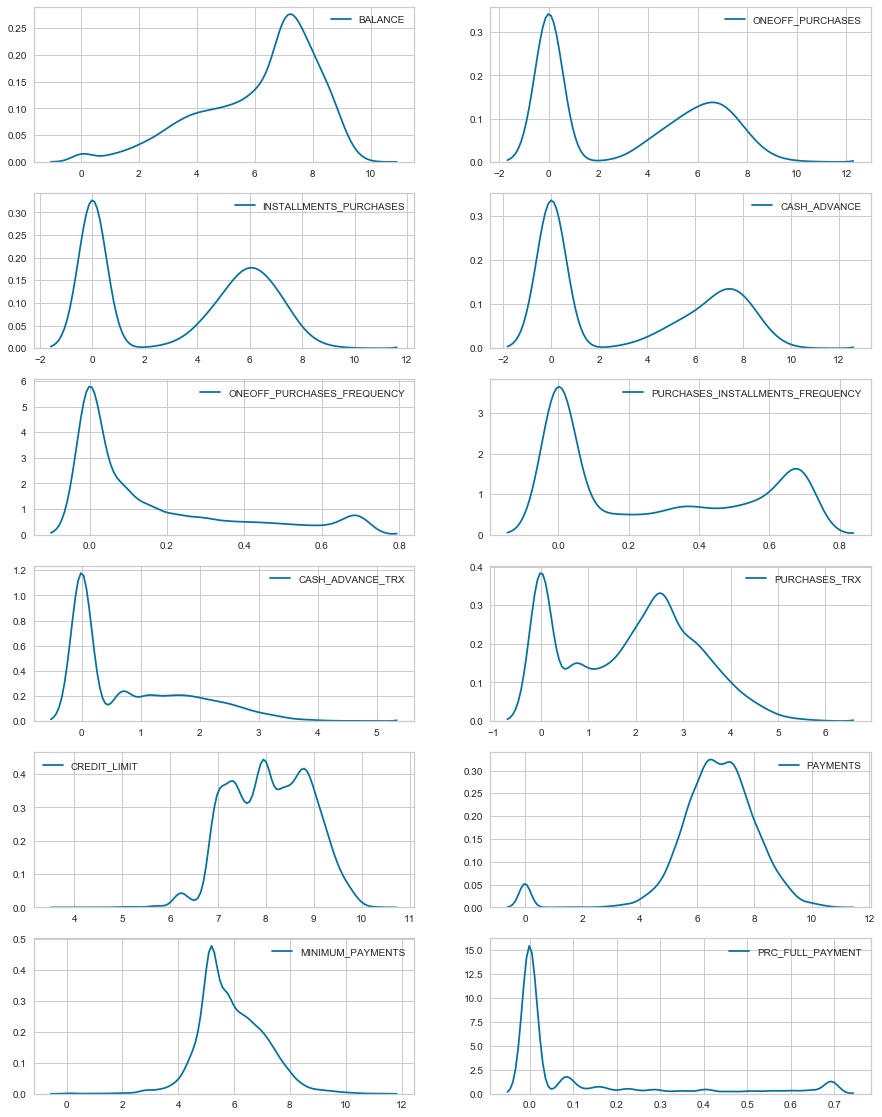

In [60]:
plt.figure(figsize=(15,20))
for i, col in enumerate(cols):
    ax = plt.subplot(6, 2, i+1)
    sns.kdeplot(df_CC[col], ax=ax)
plt.show() #On re affiche nos distributions. Ce n'est pas parfait mais c'est mieux qu'avant

#### Heatmap <a class="anchor" id="section_2_2"></a>

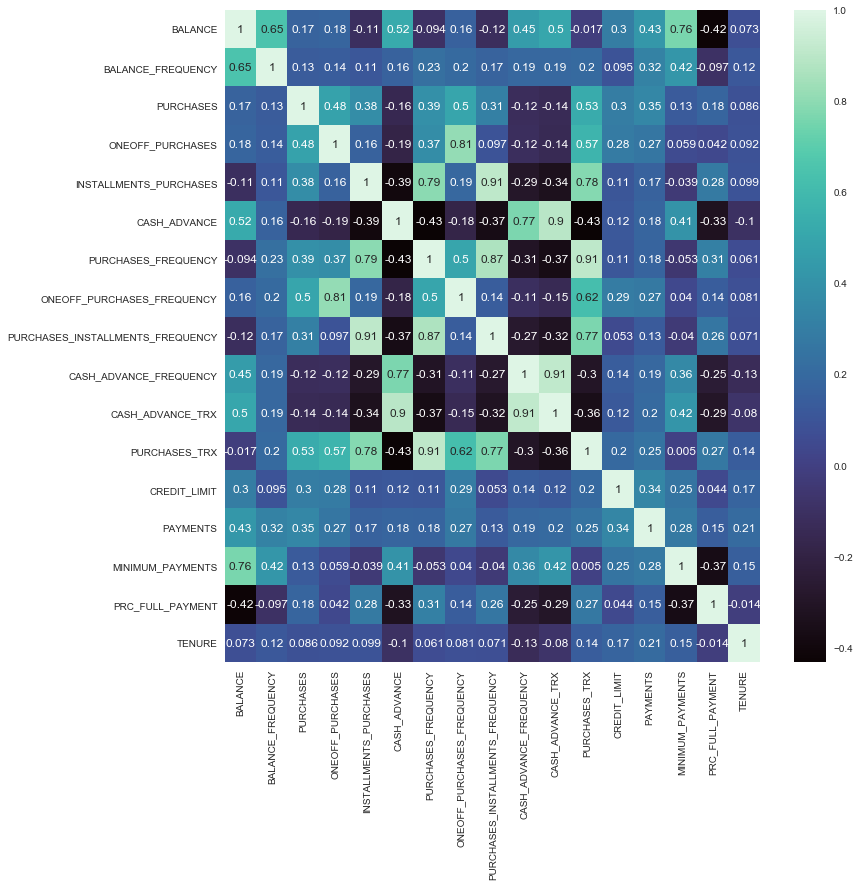

In [61]:
#On va maintenant afficher notre matrice de confusion, pour voir si certaines variables
#correlent entres elles
plt.figure(figsize=(12,12))
sns.heatmap(df_CC.corr(), annot=True, cmap='mako')
plt.show()

On retrouve effectivement quelques correlations entre certaines variables.
Mais nous avons beaucoup trop de données et beaucoup de valeurs fortement corrélé.
Pour cela on va appliquer une reduction des dimensions pour mieux interpréter les résultats.
On va donc appliquer un PCA.

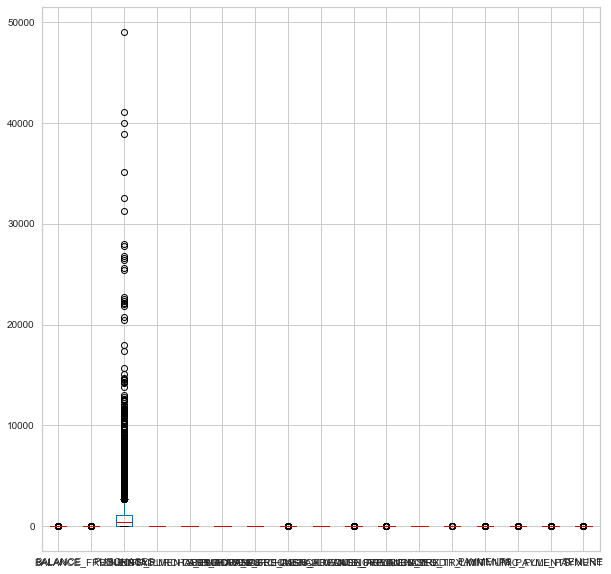

In [62]:
plt.figure(figsize=(10,10))
df_CC.boxplot()

### Entrainement du modele <a class="anchor" id="chapter3"></a>

#### Application de l'ACP <a class="anchor" id="section_3_1"></a>

In [63]:
data = pd.DataFrame(scale(df_CC), columns = df_CC.columns)
#On selectionne les colonnes sur lesquelles on veut standardiser les données 

In [64]:
pca = PCA(n_components=17)
C = pca.fit_transform(df_CC)

In [65]:
# préparation des données pour le clustering
X = df_CC[df_CC.columns].values
numero_cli = df_CC.index
variables=df_CC.columns

In [66]:
# Centrage et Réduction
X_scaled = preprocessing.StandardScaler().fit_transform(X)

In [67]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=17)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=17, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

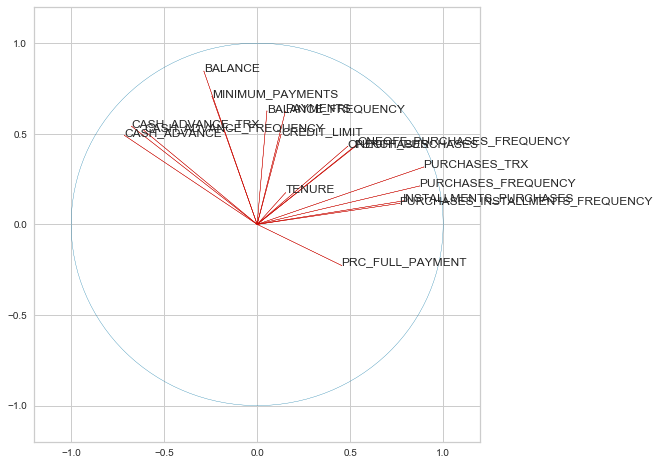

In [68]:
# coordonnées des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0]) # Plus grand score de variance
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1]) # Seconde plus grand score de variance
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, data.columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
plt.show()

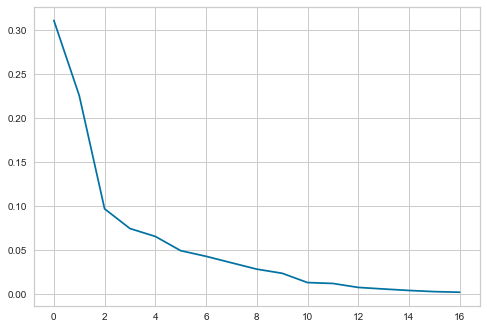

In [69]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.show()

#### Calcul du nombre de cluster <a class="anchor" id="section_3_2"></a>

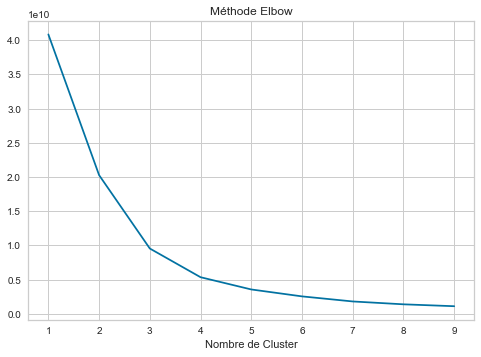

In [70]:
kmeans_models = [KMeans(n_clusters=k, random_state=23).fit(C) for k in range (1, 10)]
innertia = [model.inertia_ for model in kmeans_models]
#création de la courbe Elbow pour connaître combien de cluster on a besoin
plt.plot(range(1, 10), innertia)
plt.title('Méthode Elbow')
plt.xlabel('Nombre de Cluster')
plt.show()

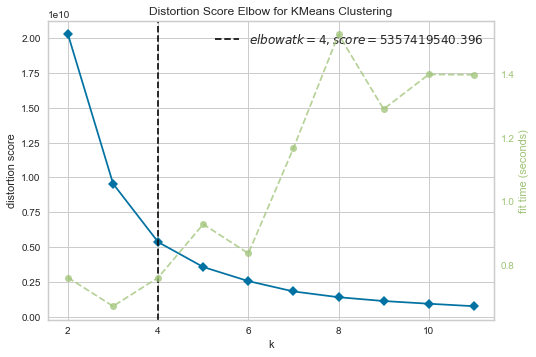

In [71]:

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(C)
visualizer.show()
#Avec YellowBrick on a une vue plus détaillée et précise sur nos nombre de clusters.
#Il semblerait que nous ayons 4 clusters..

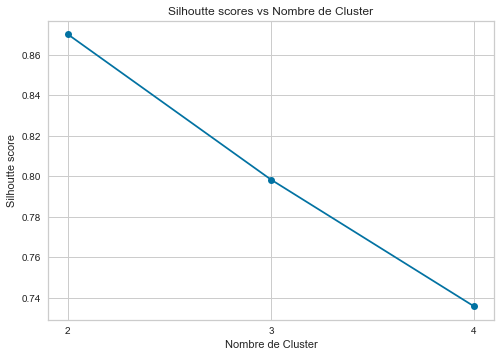

In [72]:
#Pour vérifier tout ça on va quand même comparer avec le silhouette scores



silhoutte_scores = [silhouette_score(C, model.labels_) for model in kmeans_models[1:4]]
plt.plot(range(2,5), silhoutte_scores, "bo-")
plt.xticks([2, 3, 4])
plt.title('Silhoutte scores vs Nombre de Cluster')
plt.xlabel('Nombre de Cluster')
plt.ylabel('Silhoutte score')
plt.show()

#Avec le silhouette scores on se rend compte que le nombre optimal de cluster est de 2.
#On a bien fait de vérifier.

### Evaluation du modele <a class="anchor" id="chapter4"></a>

#### Affichage de la silhouette scores <a class="anchor" id="section_4_1"></a>

In [88]:
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster, random_state=23).fit(C)
    label = kmeans.labels_
#    sil_coeff = silhouette_score(data, label, metric='euclidean')
    print("For n_clusters={" + str(n_cluster) + "}, Silhoutte scores de notre model est " + str(silhouette_score(C, kmeans.labels_)))

For n_clusters={2}, Silhoutte scores de notre model est 0.8700023049184127
For n_clusters={3}, Silhoutte scores de notre model est 0.7983346000934947
For n_clusters={4}, Silhoutte scores de notre model est 0.7357890395587149
For n_clusters={5}, Silhoutte scores de notre model est 0.6925401848567092
For n_clusters={6}, Silhoutte scores de notre model est 0.6900946774419222
For n_clusters={7}, Silhoutte scores de notre model est 0.6640378234604811
For n_clusters={8}, Silhoutte scores de notre model est 0.6537559879673953
For n_clusters={9}, Silhoutte scores de notre model est 0.6281388176832805
For n_clusters={10}, Silhoutte scores de notre model est 0.6207329622559833


In [74]:
kmeans = KMeans(n_clusters=2, random_state=23)
kmeans.fit(C)

print('Silhoutte scores de notre model est ' + str(silhouette_score(C, kmeans.labels_)))

Silhoutte scores de notre model est 0.8700023049184127


In [75]:
#Effectivement lorsque l'on fait évaluer notre modèle on se rend compte que 2 était bien le
#bon nombre

In [76]:
df_CC['cluster_id'] = kmeans.labels_ 
#On applique nos résultats dans une nouvelle colonnes dans notre dataframe

In [77]:
df_CC.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster_id
0,3.735304,0.818182,95.40,0.000000,4.568506,0.000000,0.166667,0.000000,0.080042,0.000000,0.000000,1.098612,6.908755,5.312231,4.945277,0.000000,12,0
1,8.071989,0.909091,0.00,0.000000,0.000000,8.770896,0.000000,0.000000,0.000000,0.250000,1.609438,0.000000,8.853808,8.319725,6.978531,0.200671,12,0
2,7.822504,1.000000,773.17,6.651791,0.000000,0.000000,1.000000,0.693147,0.000000,0.000000,0.000000,2.564949,8.922792,6.434654,6.442994,0.000000,12,0
3,7.419183,0.636364,1499.00,7.313220,0.000000,5.331694,0.083333,0.080042,0.000000,0.083333,0.693147,0.693147,8.922792,0.000000,5.747647,0.000000,12,0
4,6.707735,1.000000,16.00,2.833213,0.000000,0.000000,0.083333,0.080042,0.000000,0.000000,0.000000,0.693147,7.090910,6.521114,5.504483,0.000000,12,0


In [78]:
for col in cols:
    df_CC[col] = np.exp(df_CC[col])
    #On repasse à l'ancienne mesure pour avoir les résultats à la même echelle 
    #On est passé du log au exponentiel (inversement on était passé de l'exponentiel au log)

#### Visualisation de nos clusters <a class="anchor" id="section_4_2"></a>

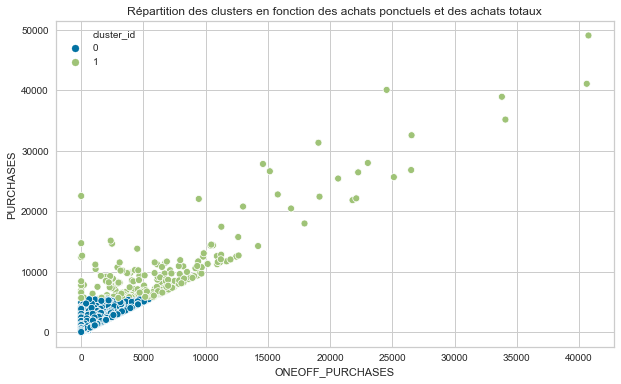

In [79]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_CC, x='ONEOFF_PURCHASES', y='PURCHASES', hue='cluster_id')
plt.title('Répartition des clusters en fonction des achats ponctuels et des achats totaux')
plt.show()

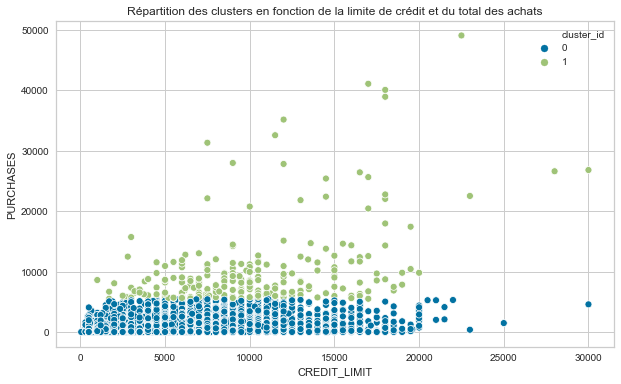

In [80]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_CC, x='CREDIT_LIMIT', y='PURCHASES', hue='cluster_id')
plt.title('Répartition des clusters en fonction de la limite de crédit et du total des achats')
plt.show()

En conclusion lorsque l'on compare nos 2 graphiques on s'appercoient que les 2 clusters crées sont soit les clients qui utilisent beaucoup leur carte ou ceux qui l'utilisent très peu.

On pourrait pousser cette comparaison avec, par exemple l'augmentation de nombre de clusters, on peut essayer avec 3 clusters.

### Déploiement <a class="anchor" id="chapter5"></a>

In [81]:
filename = 'model.pkl'
pickle.dump (kmeans, open (filename, 'wb'))